## Flamekit usage example 

In [1]:
import os
import sys
# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from flamekit.trainer import TorchTrainer
from flamekit.devices import select_device, print_cuda_available_devices
from flamekit.callbacks import TorchMetricsEvaluator, Callback
from flamekit.pbars import TQDMProgressBar
from flamekit.lr_scheduler import LRScheduler, CosineDecay, LinearDecay
from flamekit.sampling import split_dataset, SequentialSampler, RandomSampler
from flamekit.utils import set_up_reproducible_env, get_next_experiment_path

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchmetrics

In [2]:
seed = 1337
checkpoints_dir = './checkpoints'

n_classes = 10
task = 'multiclass'
average = 'macro'

epochs = 15
batch_size = 128
# Learning rate
lr0 = 1e-3
lrf = lr0 * 0.1
lr_decay = 'cosine' # None, 'linear' or 'cosine'
k_decay = 2
warmup_epochs = 0
cooldown_epochs = 0

In [3]:
set_up_reproducible_env(seed=seed)
exp_path = get_next_experiment_path(checkpoints_dir)
print("Experiments Directory:", exp_path)

Experiments Directory: checkpoints\experiment_3


In [4]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, val_indices, test_indices = split_dataset(len(trainset), val_split=0.2, test_split=0)
train_sampler = RandomSampler(train_indices)
val_sampler = SequentialSampler(val_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

print("Training Samples:", len(train_indices), "| Batches:", len(train_loader))
print("Val Samples:", len(val_indices), "| Batches:", len(val_loader))
print("Test Samples:", len(testset), "| Batches:", len(test_loader))

Training Samples: 48000 | Batches: 375
Val Samples: 12000 | Batches: 94
Test Samples: 10000 | Batches: 79


In [5]:
print_cuda_available_devices()
device = select_device(index=0, cuda=True)
print("Selected Device:", device)

Available CUDA devices:
+-------+-------------------------------------------+
| Index |                Device Name                |
+-------+-------------------------------------------+
|   0   | NVIDIA GeForce GTX 1650 with Max-Q Design |
+-------+-------------------------------------------+
Selected Device: cuda:0


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 109386


In [7]:
# Instantiate the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr0)

Train Model

In [8]:
trainer = TorchTrainer(model, device)
trainer.compile(optimizer, criterion)

In [9]:
supported_lr_decays = {
    "cosine": CosineDecay(k=k_decay),
    "linear": LinearDecay()
}

total_it = epochs * len(train_loader)
warmup_it = warmup_epochs * len(train_loader)      # Warmup iterations
cooldown_it = cooldown_epochs * len(train_loader)  # Cooldown iterations
lr_decay_it = total_it - cooldown_it
lr_decay_fn = supported_lr_decays[lr_decay] if lr_decay else None
    
class TrainingStrategy(Callback):
    
    def __init__(self) -> None:
        self.lr_scheduler = LRScheduler(
            lr0, lrf, lr_decay_it, warmup_it=warmup_it, decay_fn=lr_decay_fn
        )
        
    def on_fit_start(self, trainer, model):
        self.lr_scheduler.reset()
    
    def on_train_batch_start(self, trainer, model, batch, batch_idx):
        # Update lr
        new_lr = self.lr_scheduler.step()
        for param_group in trainer.optimizer.param_groups:
            param_group["lr"] = new_lr
        # Monitor lr
        trainer.log([('lr', new_lr)], average=False)

In [10]:
class MNISTEvaluator(TorchMetricsEvaluator):
    
    def calc_metrics(self, trainer, model, outputs, batch, batch_idx, stage) -> list[tuple]:
        # if stage == trainer.TRAIN: return [] # Only evaluate validation data or when in 'predict' stage
        return super().calc_metrics(trainer, model, outputs, batch, batch_idx, stage)
    
evaluator = MNISTEvaluator()

class Accuracy(torchmetrics.Accuracy):
    def update(self, preds, target):
        preds = preds.argmax(dim=1)
        super().update(preds, target)

metrics = {
    'acc': Accuracy(task=task, num_classes=n_classes, average=average),
    'precision': torchmetrics.Precision(task=task, num_classes=n_classes, average=average),
    'recall': torchmetrics.Recall(task=task, num_classes=n_classes, average=average),
    'f1': torchmetrics.F1Score(task=task, num_classes=n_classes, average=average),
    'auc': torchmetrics.AUROC(task=task, num_classes=n_classes, average=average),
}
evaluator.add_metrics(metrics)

In [11]:
strategy = TrainingStrategy()
pbar = TQDMProgressBar(show_remaining_time=False, show_rate=False)
callbacks = [strategy, evaluator, pbar]

# trainer.train_color = ... # NOTE: Can be overriden, blue by default
# trainer.val_color = ...   # NOTE: Can be overriden, orange by default

history = trainer.fit(
    train_loader,
    validation_loader=val_loader,
    epochs=epochs,
    dest_path=exp_path,
    monitor='val_loss',
    mode='min',
    prefix=model.__class__.__name__,
    save_best=True,
    callbacks=callbacks
)

Epoch 1/15: 100% |██████████████████████████████| 375/375 [00:58, lr=0.001, loss=0.498, acc=0.855, auc=0.984, f1=0.847, precision=0.86, recall=0.855, val_loss=0.284, val_acc=0.916, val_auc=0.995, val_f1=0.912, val_precision=0.917, val_recall=0.916]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.2836_1_best.tar)


Epoch 2/15: 100% |██████████████████████████████| 375/375 [00:49, lr=0.000999, loss=0.244, acc=0.927, auc=0.996, f1=0.924, precision=0.928, recall=0.927, val_loss=0.212, val_acc=0.935, val_auc=0.997, val_f1=0.932, val_precision=0.936, val_recall=0.935]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.2118_2_best.tar)


Epoch 3/15: 100% |██████████████████████████████| 375/375 [00:49, lr=0.000996, loss=0.182, acc=0.946, auc=0.998, f1=0.944, precision=0.947, recall=0.946, val_loss=0.186, val_acc=0.941, val_auc=0.998, val_f1=0.939, val_precision=0.943, val_recall=0.941]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.1862_3_best.tar)


Epoch 4/15: 100% |██████████████████████████████| 375/375 [00:50, lr=0.000989, loss=0.146, acc=0.956, auc=0.998, f1=0.955, precision=0.957, recall=0.956, val_loss=0.159, val_acc=0.95, val_auc=0.998, val_f1=0.949, val_precision=0.952, val_recall=0.95]  


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.1589_4_best.tar)


Epoch 5/15: 100% |██████████████████████████████| 375/375 [00:50, lr=0.000973, loss=0.123, acc=0.963, auc=0.999, f1=0.961, precision=0.963, recall=0.963, val_loss=0.14, val_acc=0.955, val_auc=0.999, val_f1=0.953, val_precision=0.956, val_recall=0.955] 


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.14_5_best.tar)


Epoch 6/15: 100% |██████████████████████████████| 375/375 [00:44, lr=0.000944, loss=0.104, acc=0.967, auc=0.999, f1=0.966, precision=0.967, recall=0.967, val_loss=0.125, val_acc=0.962, val_auc=0.999, val_f1=0.96, val_precision=0.962, val_recall=0.962] 


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.1246_6_best.tar)


Epoch 7/15: 100% |██████████████████████████████| 375/375 [00:55, lr=0.000899, loss=0.0878, acc=0.972, auc=0.999, f1=0.971, precision=0.973, recall=0.972, val_loss=0.104, val_acc=0.968, val_auc=0.999, val_f1=0.966, val_precision=0.967, val_recall=0.968] 


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.1038_7_best.tar)


Epoch 8/15: 100% |██████████████████████████████| 375/375 [00:53, lr=0.000832, loss=0.0763, acc=0.976, auc=1, f1=0.975, precision=0.976, recall=0.976, val_loss=0.122, val_acc=0.962, val_auc=0.999, val_f1=0.96, val_precision=0.962, val_recall=0.962] 
Epoch 9/15: 100% |██████████████████████████████| 375/375 [00:48, lr=0.000742, loss=0.0688, acc=0.978, auc=1, f1=0.977, precision=0.979, recall=0.978, val_loss=0.104, val_acc=0.97, val_auc=0.999, val_f1=0.968, val_precision=0.969, val_recall=0.97]   


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.1035_9_best.tar)


Epoch 10/15: 100% |██████████████████████████████| 375/375 [00:48, lr=0.000628, loss=0.0577, acc=0.981, auc=1, f1=0.981, precision=0.982, recall=0.981, val_loss=0.1, val_acc=0.97, val_auc=0.999, val_f1=0.969, val_precision=0.97, val_recall=0.97]      


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.1005_10_best.tar)


Epoch 11/15: 100% |██████████████████████████████| 375/375 [00:48, lr=0.000497, loss=0.0504, acc=0.984, auc=1, f1=0.984, precision=0.984, recall=0.984, val_loss=0.0969, val_acc=0.972, val_auc=0.999, val_f1=0.97, val_precision=0.972, val_recall=0.972] 


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.0969_11_best.tar)


Epoch 12/15: 100% |██████████████████████████████| 375/375 [00:50, lr=0.000359, loss=0.041, acc=0.987, auc=1, f1=0.987, precision=0.987, recall=0.987, val_loss=0.0983, val_acc=0.97, val_auc=0.999, val_f1=0.969, val_precision=0.971, val_recall=0.97]  
Epoch 13/15: 100% |██████████████████████████████| 375/375 [00:52, lr=0.000231, loss=0.0352, acc=0.99, auc=1, f1=0.99, precision=0.99, recall=0.99, val_loss=0.0909, val_acc=0.974, val_auc=0.999, val_f1=0.972, val_precision=0.974, val_recall=0.974]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.0909_13_best.tar)


Epoch 14/15: 100% |██████████████████████████████| 375/375 [00:56, lr=0.000137, loss=0.0307, acc=0.991, auc=1, f1=0.991, precision=0.991, recall=0.991, val_loss=0.0883, val_acc=0.975, val_auc=0.999, val_f1=0.974, val_precision=0.975, val_recall=0.975]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.0883_14_best.tar)


Epoch 15/15: 100% |██████████████████████████████| 375/375 [00:55, lr=0.0001, loss=0.0275, acc=0.993, auc=1, f1=0.993, precision=0.993, recall=0.993, val_loss=0.0882, val_acc=0.975, val_auc=0.999, val_f1=0.974, val_precision=0.975, val_recall=0.975]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_3\MLP_val-loss_0.0882_15_best.tar)
[END] Training finished


Plot training metrics

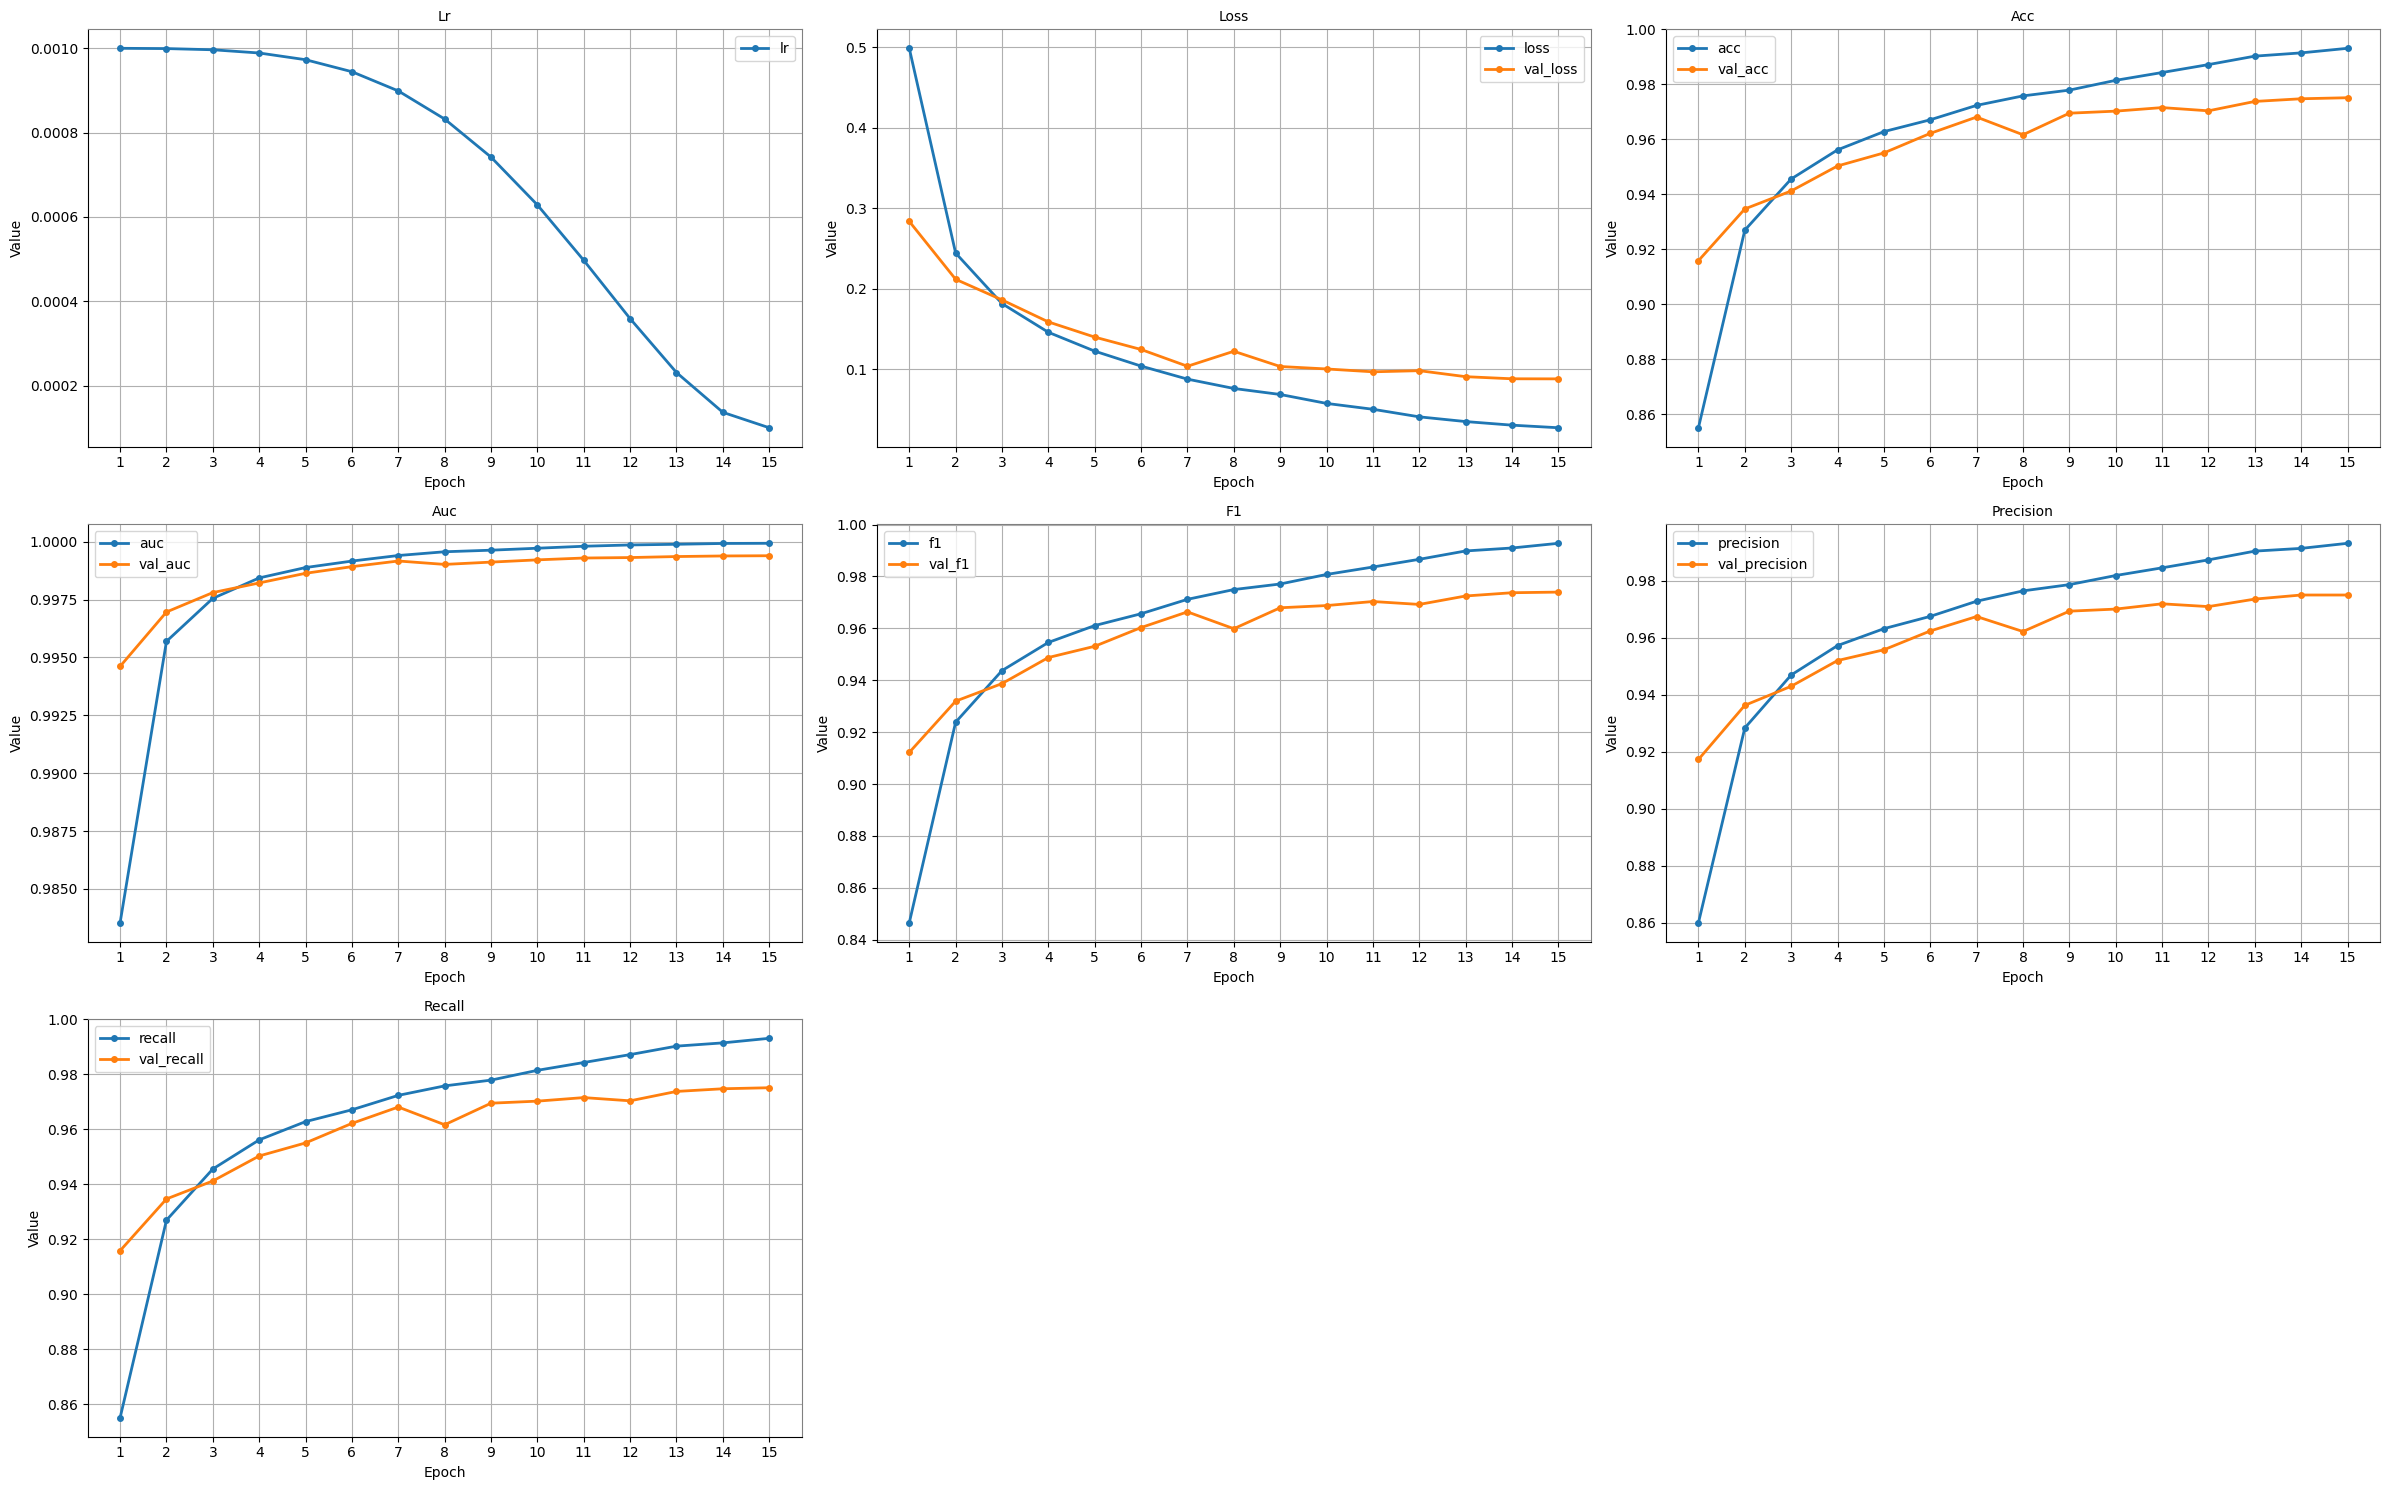

In [12]:
trainer.plot()

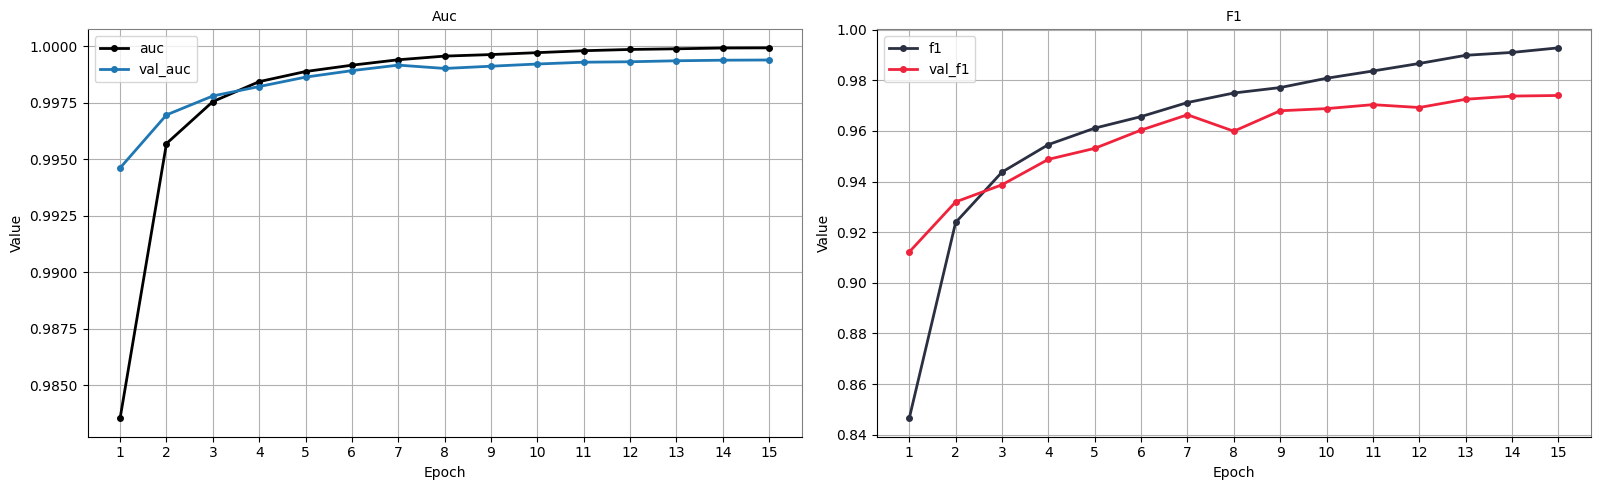

In [13]:
trainer.plot(metrics=['f1', 'auc'], colors=[['#000000', '#1f77b4'], ['#2B2F42', '#EF233C']], dest_path=exp_path/'customization_example.png')

Load best checkpoint

In [14]:
trainer.load_best()

[OK] Checkpoint 'checkpoints\experiment_3\MLP_val-loss_0.0882_15_best.tar' has been loaded successfully


Evaluate on testset

In [15]:
trainer.predict(test_loader, callbacks=callbacks)

Predicting: 100% |██████████████████████████████| 79/79 [00:08, loss=0.0771, acc=0.976, auc=0.999, f1=0.975, precision=0.976, recall=0.976]
